Loaded 8,742 rows, 94 columns

Rows per Method:
Method
Direct (Non-Reasoning)    2394
Prompt2DAG (Template)     1578
Prompt2DAG (LLM)          2043
Prompt2DAG (Hybrid)       2043
Direct (Reasoning)         684
Name: count, dtype: int64

ORT_raw range: (-13.5, 7.6899999999999995)
ORT_scaled range: (0.0, 10.0)
Metadata entries: 38
df_meta: (38, 15)
Unique pipelines in evaluation: 38
Unique pipelines in metadata:  38
Pipelines in eval but missing metadata: 0
df_pipe: (190, 24)
Unique archetypes: 18

Top archetypes by pipeline count:
archetype
Moderate (3–4) | Linear | Seq. APIs              9
Simple (1–2) | Linear | Seq. APIs                3
Simple (1–2) | Linear | DB-centric               3
Complex (5–6) | Fan-out/in | File-based          3
Complex (5–6) | Branch-merge | Orchestrated      2
Moderate (3–4) | Sensor-gated | DB-centric       2
Complex (5–6) | Fan-out/in | Par. API fanout     2
Advanced (7–8) | Branch-merge | Orchestrated     2
Complex (5–6) | Branch-merge | DB-centric     

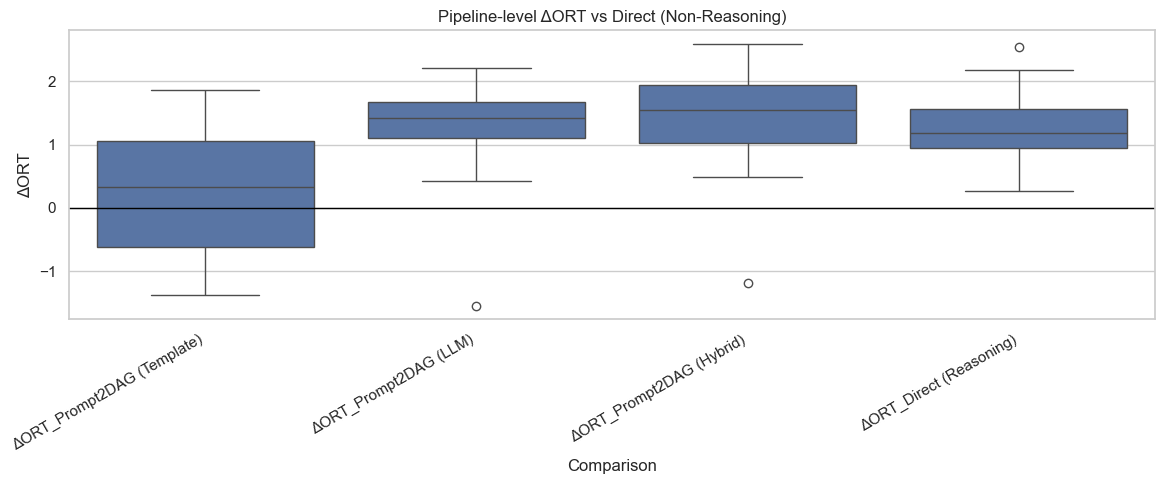

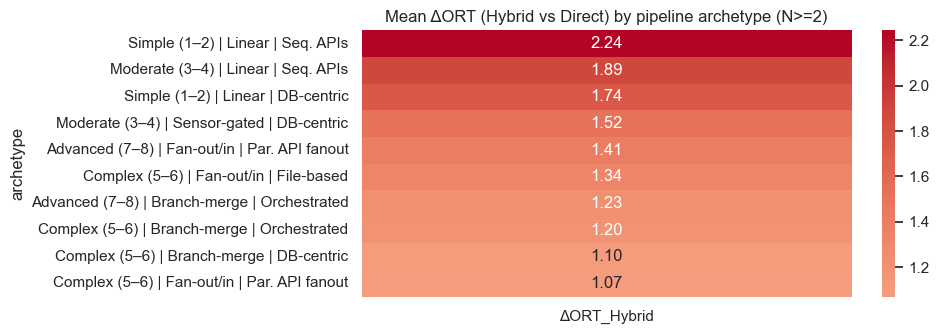


TOP + WORST pipelines by ΔORT_Prompt2DAG (Template) (vs Direct)

Top improvements:
                                    pipeline_name                     domain_category                           archetype  Direct (Non-Reasoning)  ΔORT_Prompt2DAG (Template)
synthetic-gener.../synthetic_linear_01_report_gen                     Sales Analytics Moderate (3–4) | Linear | Seq. APIs                   4.695                       1.862
         Ferlab-Ste-Just.../etl_import_ensembl.py             Genomic Data Processing   Simple (1–2) | Linear | Seq. APIs                   4.737                       1.668
             Environmental_Monitoring_Network.txt         Environmental Risk Analysis Moderate (3–4) | Linear | Seq. APIs                   5.581                       1.454
              Procurement_Supplier_Validation.txt                        Data Quality Moderate (3–4) | Linear | Seq. APIs                   5.626                       1.453
               Medical_Facility_Accessibility.

In [1]:
# %% [markdown]
# # Pipeline-level performance analysis across 5 methods (with metadata)
#
# **Goal:** analyze *pipeline-level* performance across the five methods without printing all pipelines in a massive table.
#
# We will:
# 1. Load evaluation data (`all_sessions_cleaned.csv`)
# 2. Load pipeline metadata (`pipeline_analysis_complete.json`)
# 3. Aggregate runs → Pipeline × Method
# 4. Construct compact **Pipeline Archetypes** for readable grouping
# 5. Report:
#    - Method performance per archetype (Pass%, ORT, Combined)
#    - Δ vs Direct (Non-Reasoning) per archetype
#    - Win-rates: how often each method beats Direct per pipeline
#    - Representative pipelines (top wins / losses) for qualitative discussion
#
# This is designed for an **Appendix** and for supporting narrative in the main paper.

# %%
import json
from pathlib import Path

import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 240)

# %% [markdown]
# ## 0) Paths and configuration

# %%
CSV_PATH = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv"
META_JSON_PATH = "/Users/abubakarialidu/Desktop/Data Result/pipeline_analysis_results/pipeline_analysis_complete.json"

METHOD_ORDER = [
    "Direct (Non-Reasoning)",
    "Prompt2DAG (Template)",
    "Prompt2DAG (LLM)",
    "Prompt2DAG (Hybrid)",
    "Direct (Reasoning)",
]

ORCH_ORDER = ["airflow", "dagster", "prefect"]

# ORT weights (match your main analysis)
ALPHA_CRIT = 2.0
BETA_MAJOR = 1.0
GAMMA_MINOR = 0.25

# When comparing methods pipeline-level, which outcome to prioritize?
PRIMARY_OUTCOME = "ORT_scaled"     # recommend: ORT_scaled (robust + accounts for pass/fail)
SECONDARY_OUTCOME = "Combined_Score"

# %% [markdown]
# ## 1) Load evaluation data

# %%
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

# normalize orchestrator and passed
df["Orchestrator"] = df["Orchestrator"].astype(str).str.lower().str.strip()
if df["Passed"].dtype != bool:
    df["Passed"] = df["Passed"].astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False})

# %% [markdown]
# ## 2) Classify the 5 methods

# %%
def classify_method(row):
    workflow = row.get("Workflow", "")
    strategy = str(row.get("Strategy") or "").lower()
    if workflow == "Direct":
        return "Direct (Non-Reasoning)"
    elif workflow == "Reasoning":
        return "Direct (Reasoning)"
    elif workflow == "Prompt2DAG":
        if "template" in strategy:
            return "Prompt2DAG (Template)"
        elif "llm" in strategy:
            return "Prompt2DAG (LLM)"
        elif "hybrid" in strategy:
            return "Prompt2DAG (Hybrid)"
        else:
            return f"Prompt2DAG ({row.get('Strategy','Unknown')})"
    return workflow

df["Method"] = df.apply(classify_method, axis=1)
df = df[df["Method"].isin(METHOD_ORDER)].copy()

print("\nRows per Method:")
print(df["Method"].value_counts().reindex(METHOD_ORDER))

# %% [markdown]
# ## 3) Ensure issues + compute ORT (scaled) consistent with main analysis

# %%
for c in ["Critical_Issues", "Major_Issues", "Minor_Issues"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = df[c].fillna(0)

df["Total_Issues"] = df["Critical_Issues"] + df["Major_Issues"] + df["Minor_Issues"]

# Base score: Combined if passed, else 0
df["Base_Score"] = np.where(df["Passed"] == True, df["Combined_Score"], 0.0)

df["Penalty"] = (
    ALPHA_CRIT * df["Critical_Issues"]
    + BETA_MAJOR * df["Major_Issues"]
    + GAMMA_MINOR * df["Minor_Issues"]
)

df["ORT_raw"] = df["Base_Score"] - df["Penalty"]

# Use global scaling to [0,10] (same as your earlier approach)
ort_min, ort_max = df["ORT_raw"].min(), df["ORT_raw"].max()
df["ORT_scaled"] = 0.0
if ort_max > ort_min:
    df["ORT_scaled"] = 10.0 * (df["ORT_raw"] - ort_min) / (ort_max - ort_min)

print("\nORT_raw range:", (df["ORT_raw"].min(), df["ORT_raw"].max()))
print("ORT_scaled range:", (df["ORT_scaled"].min(), df["ORT_scaled"].max()))

# %% [markdown]
# ## 4) Load pipeline metadata JSON and build a metadata DataFrame
#
# We use `standard_complexity_score` from the JSON (matches your appendix design).
# If missing, we fall back to `complexity_score`.

# %%
meta_path = Path(META_JSON_PATH)
assert meta_path.exists(), f"Metadata JSON not found: {META_JSON_PATH}"

with open(meta_path, "r", encoding="utf-8") as f:
    meta_json = json.load(f)

entries = meta_json.get("analyses", [])
print("Metadata entries:", len(entries))

meta_records = []
for e in entries:
    src = e.get("source_file", "")
    pipeline_id = src.replace(".txt", "")  # matches the pattern you used previously

    topo = e.get("topology", {}) or {}
    proc = e.get("processing", {}) or {}
    ext  = e.get("external_services", {}) or {}
    comp = e.get("complexity", {}) or {}
    sched = e.get("scheduling", {}) or {}

    # complexity score: prefer standard_complexity_score
    std_c = comp.get("standard_complexity_score", None)
    raw_c = comp.get("complexity_score", None)
    use_c = std_c if std_c is not None else raw_c

    meta_records.append({
        "Pipeline_ID": pipeline_id,
        "pipeline_name": e.get("pipeline_name", pipeline_id),
        "domain_category": e.get("domain_category"),
        "business_domain": e.get("business_domain"),
        "topology_pattern": topo.get("pattern"),
        "parallelization_level": topo.get("parallelization_level"),
        "has_sensors": topo.get("has_sensors"),
        "has_branches": topo.get("has_branches"),
        "max_parallel_width": topo.get("max_parallel_width"),
        "branch_depth": topo.get("branch_depth"),
        "total_tasks": proc.get("total_tasks"),
        "etl_pattern": proc.get("etl_pattern"),
        "service_integration_pattern": ext.get("service_integration_pattern"),
        "schedule_type": sched.get("schedule_type"),
        "complexity_score": use_c
    })

df_meta = pd.DataFrame(meta_records)
print("df_meta:", df_meta.shape)
df_meta.head(3)

# %% [markdown]
# ### Join coverage check

# %%
print("Unique pipelines in evaluation:", df["Pipeline_ID"].nunique())
print("Unique pipelines in metadata: ", df_meta["Pipeline_ID"].nunique())

missing_meta = sorted(set(df["Pipeline_ID"]) - set(df_meta["Pipeline_ID"]))
print("Pipelines in eval but missing metadata:", len(missing_meta))
if missing_meta:
    print("Example missing:", missing_meta[:5])

# %% [markdown]
# ## 5) Aggregate runs → Pipeline × Method
#
# Pipeline-level means are what you want for “per pipeline performance”.
# This prevents a pipeline with more runs from dominating the analysis.

# %%
agg_cols = ["Static_Score", "Compliance_Score", "Combined_Score", "ORT_scaled", "Total_Issues", "Critical_Issues"]
pipe_method = (
    df
    .groupby(["Pipeline_ID", "Method"], observed=True)
    .agg(
        N_runs=("Passed", "size"),
        Pass_Rate=("Passed", "mean"),
        SAT=("Static_Score", "mean"),
        PCT=("Compliance_Score", "mean"),
        Combined=("Combined_Score", "mean"),
        ORT=("ORT_scaled", "mean"),
        Total_Issues=("Total_Issues", "mean"),
        Critical_Issues=("Critical_Issues", "mean"),
    )
    .reset_index()
)

# Merge metadata
df_pipe = pipe_method.merge(df_meta, on="Pipeline_ID", how="left")
print("df_pipe:", df_pipe.shape)
df_pipe.head(3)

# %% [markdown]
# ## 6) Create a simpler creative classification: Pipeline Archetypes
#
# To avoid listing 38 pipelines, we classify each pipeline into a small number of **archetypes**:
#
# - Complexity bucket: Simple / Moderate / Complex / Advanced
# - Topology family: Linear / Fan-out-in / Branch-merge / Sensor-gated / Other
# - Integration family: Sequential APIs / Orchestrated / Parallel fanout / DB-centric / File-based / Other
#
# This usually yields a manageable number of groups.

# %%
def complexity_bucket(c):
    if pd.isna(c):
        return "Unknown"
    c = int(c)
    if c <= 2:
        return "Simple (1–2)"
    if c <= 4:
        return "Moderate (3–4)"
    if c <= 6:
        return "Complex (5–6)"
    return "Advanced (7–8)"

def topology_family(p):
    p = str(p or "").lower()
    if "linear" in p:
        return "Linear"
    if "fan_out" in p:
        return "Fan-out/in"
    if "branch" in p:
        return "Branch-merge"
    if "sensor" in p:
        return "Sensor-gated"
    return "Other"

def integration_family(x):
    x = str(x or "").lower()
    if "sequential_api" in x:
        return "Seq. APIs"
    if "orchestrated_services" in x:
        return "Orchestrated"
    if "parallel_api_fanout" in x:
        return "Par. API fanout"
    if "api_enrichment" in x:
        return "API enrich."
    if "database_centric" in x:
        return "DB-centric"
    if "file_processing" in x:
        return "File-based"
    return "Other"

df_pipe["complexity_bucket"] = df_pipe["complexity_score"].apply(complexity_bucket)
df_pipe["topology_family"] = df_pipe["topology_pattern"].apply(topology_family)
df_pipe["integration_family"] = df_pipe["service_integration_pattern"].apply(integration_family)

df_pipe["archetype"] = (
    df_pipe["complexity_bucket"] + " | " +
    df_pipe["topology_family"] + " | " +
    df_pipe["integration_family"]
)

# Show how many pipelines per archetype (pipeline-level unique)
pipe_level_arche = (
    df_pipe[["Pipeline_ID", "archetype", "complexity_bucket", "topology_family", "integration_family"]]
    .drop_duplicates()
)
print("Unique archetypes:", pipe_level_arche["archetype"].nunique())

print("\nTop archetypes by pipeline count:")
print(pipe_level_arche["archetype"].value_counts().head(15).to_string())

# %% [markdown]
# ## 7) Compact table: Method performance by archetype
#
# This is a good appendix table:
# - manageable number of rows (archetypes that appear)
# - columns for Pass rate, ORT, Combined
# - includes N pipelines and N runs

# %%
arch_method = (
    df_pipe
    .groupby(["archetype", "Method"], observed=True)
    .agg(
        N_pipelines=("Pipeline_ID", "nunique"),
        N_runs=("N_runs", "sum"),
        Pass_Rate=("Pass_Rate", "mean"),   # mean pipeline pass-rate within archetype
        ORT=("ORT", "mean"),
        Combined=("Combined", "mean"),
        SAT=("SAT", "mean"),
        PCT=("PCT", "mean"),
    )
    .reset_index()
)

arch_method["Pass%"] = (100 * arch_method["Pass_Rate"]).round(1)

# keep only archetypes with enough pipelines to be meaningful
arch_method = arch_method[arch_method["N_pipelines"] >= 2].copy()

arch_method["Method"] = pd.Categorical(arch_method["Method"], METHOD_ORDER, ordered=True)
arch_method = arch_method.sort_values(["archetype", "Method"])

print("="*120)
print("TABLE P1: Pipeline archetype × Method (mean over pipelines)")
print("="*120)
print(arch_method[["archetype","Method","N_pipelines","N_runs","Pass%","ORT","Combined","SAT","PCT"]].round(3).to_string(index=False))

# %% [markdown]
# ## 8) Pipeline-level Δ vs Direct baseline (per archetype)
#
# We compute, for each pipeline:
# - ΔORT(method) = ORT(method) - ORT(Direct Non-Reasoning)
# - ΔPass(method) = PassRate(method) - PassRate(Direct Non-Reasoning)
#
# Then average these deltas within each archetype.
#
# This is usually the most interpretable “where Prompt2DAG helps” view.

# %%
baseline = "Direct (Non-Reasoning)"

# Pivot to pipeline-level wide form for ORT + PassRate
pivot_ort = df_pipe.pivot_table(index="Pipeline_ID", columns="Method", values="ORT").reindex(columns=METHOD_ORDER)
pivot_pass = df_pipe.pivot_table(index="Pipeline_ID", columns="Method", values="Pass_Rate").reindex(columns=METHOD_ORDER)

# Add archetype labels (one per pipeline)
pipe_labels = (
    df_pipe[["Pipeline_ID","archetype","complexity_bucket","topology_family","integration_family","pipeline_name","domain_category"]]
    .drop_duplicates()
    .set_index("Pipeline_ID")
)

df_delta = pipe_labels.join(pivot_ort, how="left")
df_delta_pass = pipe_labels.join(pivot_pass, how="left", rsuffix="_pass")

# delta columns
for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    df_delta[f"ΔORT_{m}"] = df_delta[m] - df_delta[baseline]
    df_delta_pass[f"ΔPass_{m}"] = df_delta_pass[m] - df_delta_pass[baseline]

# summarize by archetype
delta_cols = [c for c in df_delta.columns if c.startswith("ΔORT_")]
pass_delta_cols = [c for c in df_delta_pass.columns if c.startswith("ΔPass_")]

delta_by_arch = (
    df_delta.groupby("archetype")[delta_cols]
    .agg(["mean","median","count"])
)
# flatten columns
delta_by_arch.columns = [f"{a}_{b}" for a,b in delta_by_arch.columns]
delta_by_arch = delta_by_arch.reset_index()

# attach pipeline counts per archetype
arch_counts = pipe_labels["archetype"].value_counts().rename_axis("archetype").reset_index(name="N_pipelines")
delta_by_arch = delta_by_arch.merge(arch_counts, on="archetype", how="left")
delta_by_arch = delta_by_arch[delta_by_arch["N_pipelines"] >= 2].copy()

# pass delta summary
pass_by_arch = (
    df_delta_pass.groupby("archetype")[pass_delta_cols]
    .mean()
    .reset_index()
    .merge(arch_counts, on="archetype", how="left")
)
pass_by_arch = pass_by_arch[pass_by_arch["N_pipelines"] >= 2].copy()

print("="*120)
print("TABLE P2: Mean ΔORT vs Direct by archetype (pipeline-level)")
print("="*120)
show_cols = ["archetype","N_pipelines"] + [c for c in delta_by_arch.columns if c.endswith("_mean")]
print(delta_by_arch[show_cols].round(3).to_string(index=False))

print("\n" + "="*120)
print("TABLE P3: Mean ΔPass vs Direct by archetype (pipeline-level)")
print("="*120)
print(pass_by_arch.round(3).to_string(index=False))

# %% [markdown]
# ## 9) Win-rate analysis: How often does each method beat Direct per pipeline?
#
# This avoids any “one pipeline dominates” issue and produces a clean statement like:
# - “Prompt2DAG Hybrid beats Direct on ORT in X% of pipelines.”

# %%
def win_rate(df_wide, baseline_col, method_col):
    sub = df_wide[[baseline_col, method_col]].dropna()
    if len(sub) == 0:
        return np.nan, 0
    return (sub[method_col] > sub[baseline_col]).mean(), len(sub)

win_rows = []
for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    wr, n = win_rate(pivot_ort, baseline, m)
    win_rows.append({"Metric":"ORT", "Method":m, "WinRate":wr, "N_pipelines":n})

for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    wr, n = win_rate(pivot_pass, baseline, m)
    win_rows.append({"Metric":"Pass_Rate", "Method":m, "WinRate":wr, "N_pipelines":n})

win_df = pd.DataFrame(win_rows)
win_df["WinRate%"] = (100*win_df["WinRate"]).round(1)

print("="*120)
print("TABLE P4: Pipeline-level win-rate vs Direct (Non-Reasoning)")
print("="*120)
print(win_df[["Metric","Method","N_pipelines","WinRate%"]].to_string(index=False))

# %% [markdown]
# ## 10) Statistical tests (paired across pipelines)
#
# Since each pipeline provides a paired comparison (Direct vs method),
# paired tests are appropriate:
# - Wilcoxon signed-rank (robust)
# - Paired t-test (if approximately normal)
#
# We'll do Wilcoxon by default.

# %%
def paired_tests(wide, base, other, label):
    sub = wide[[base, other]].dropna()
    if len(sub) < 5:
        return {"label": label, "N": len(sub), "wilcoxon_p": np.nan, "ttest_p": np.nan, "delta_mean": np.nan}
    delta = sub[other] - sub[base]
    # Wilcoxon requires non-zero diffs; handle all-zero
    if np.allclose(delta.values, 0):
        w_p = 1.0
    else:
        w_p = stats.wilcoxon(delta).pvalue
    t_p = stats.ttest_rel(sub[other], sub[base]).pvalue
    return {"label": label, "N": len(sub), "wilcoxon_p": w_p, "ttest_p": t_p, "delta_mean": delta.mean()}

tests = []
for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    tests.append(paired_tests(pivot_ort, baseline, m, f"ORT: {m} vs Direct"))
for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    tests.append(paired_tests(pivot_pass, baseline, m, f"PassRate: {m} vs Direct"))

tests_df = pd.DataFrame(tests)
print("="*120)
print("TABLE P5: Paired tests across pipelines (vs Direct)")
print("="*120)
print(tests_df.round(6).to_string(index=False))

# %% [markdown]
# ## 11) Visuals: (A) distribution of ΔORT across pipelines
#
# This is a clean plot for the appendix:
# - shows median improvement, variance, and outliers.

# %%
plot_df = df_delta.reset_index()[["Pipeline_ID","complexity_bucket","topology_family","integration_family","pipeline_name",
                                 "ΔORT_Prompt2DAG (Template)",
                                 "ΔORT_Prompt2DAG (LLM)",
                                 "ΔORT_Prompt2DAG (Hybrid)",
                                 "ΔORT_Direct (Reasoning)"]].copy()

# melt for seaborn
plot_long = plot_df.melt(
    id_vars=["Pipeline_ID","complexity_bucket","topology_family","integration_family"],
    value_vars=[c for c in plot_df.columns if c.startswith("ΔORT_")],
    var_name="Comparison",
    value_name="ΔORT"
)

plt.figure(figsize=(12,5))
sns.boxplot(data=plot_long, x="Comparison", y="ΔORT")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=30, ha="right")
plt.title("Pipeline-level ΔORT vs Direct (Non-Reasoning)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 12) Visuals: (B) heatmap of ΔORT by archetype (Hybrid vs Direct)
#
# This gives a compact “where Hybrid helps most” picture.

# %%
# compute mean delta per archetype for Hybrid
hyb = df_delta.groupby("archetype")["ΔORT_Prompt2DAG (Hybrid)"].mean().dropna()
arch_sizes = pipe_labels["archetype"].value_counts()

heat = pd.DataFrame({
    "ΔORT_Hybrid": hyb,
    "N_pipelines": arch_sizes
}).reset_index()

heat = heat[heat["N_pipelines"] >= 2].copy()
heat = heat.sort_values("ΔORT_Hybrid", ascending=False)

plt.figure(figsize=(10, max(3, 0.35*len(heat))))
sns.heatmap(
    heat.set_index("archetype")[["ΔORT_Hybrid"]],
    annot=True, fmt=".2f", cmap="coolwarm", center=0
)
plt.title("Mean ΔORT (Hybrid vs Direct) by pipeline archetype (N>=2)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 13) Representative pipelines (top wins / top losses)
#
# Instead of listing all pipelines, you can report:
# - Top 5 pipelines where each method improves ORT the most vs Direct
# - Top 5 where it hurts the most
#
# This supports qualitative discussion.

# %%
def top_k(df_delta, delta_col, k=5):
    sub = df_delta.dropna(subset=[delta_col, baseline]).copy()
    cols = ["pipeline_name","domain_category","archetype", baseline, delta_col]
    best = sub.sort_values(delta_col, ascending=False)[cols].head(k)
    worst = sub.sort_values(delta_col, ascending=True)[cols].head(k)
    return best, worst

for m in ["Prompt2DAG (Template)", "Prompt2DAG (LLM)", "Prompt2DAG (Hybrid)", "Direct (Reasoning)"]:
    col = f"ΔORT_{m}"
    best, worst = top_k(df_delta, col, k=5)

    print("\n" + "="*120)
    print(f"TOP + WORST pipelines by {col} (vs Direct)")
    print("="*120)
    print("\nTop improvements:")
    print(best.round(3).to_string(index=False))
    print("\nWorst regressions:")
    print(worst.round(3).to_string(index=False))

# %% [markdown]
# ## 14) Optional: pipeline-family grouping (Real-world vs Synthetic)
#
# If your Pipeline_ID naming allows detection, you can group and compare.
# This is often publishable in the main paper (one small table).

# %%
def pipeline_family(pid: str) -> str:
    pid = str(pid).lower()
    if "synthetic" in pid:
        return "Synthetic"
    return "Real-world"

pipe_labels2 = pipe_labels.copy()
pipe_labels2["pipeline_family"] = pipe_labels2.index.to_series().apply(pipeline_family)

df_delta_family = df_delta.join(pipe_labels2[["pipeline_family"]], how="left")

family_summary = (
    df_delta_family.groupby("pipeline_family")[[
        "ΔORT_Prompt2DAG (Template)",
        "ΔORT_Prompt2DAG (LLM)",
        "ΔORT_Prompt2DAG (Hybrid)",
        "ΔORT_Direct (Reasoning)"
    ]]
    .agg(["mean","median","count"])
)

family_summary.columns = [f"{a}_{b}" for a,b in family_summary.columns]
family_summary = family_summary.reset_index()

print("="*120)
print("TABLE P6: ΔORT vs Direct by pipeline family")
print("="*120)
print(family_summary.round(3).to_string(index=False))

Loaded 8,742 rows, 94 columns
Non-NaN counts:
  ComplianceDim_structure_validity: 8,742
  Compliance_Score:   8,742

Rows per Method:
Method
Direct (Non-Reasoning)    2394
Prompt2DAG (Template)     1578
Prompt2DAG (LLM)          2043
Prompt2DAG (Hybrid)       2043
Direct (Reasoning)         684
Name: count, dtype: int64

Corr(Combined, ORT_capped):
                Combined_Score  ORT_capped
Combined_Score           1.000       0.702
ORT_capped               0.702       1.000
Rows with both structure + platform: 8742

Category counts:
StructPlat_Category
Mixed                  3459
LowStruct_LowPlat      3419
HighStruct_HighPlat    1815
LowStruct_HighPlat       49
Name: count, dtype: int64
TABLE R1: Run-level means by Struct×Platform regime (all methods)
                     ComplianceDim_structure_validity  Compliance_Score  Static_Score  Combined_Score  ORT_capped  Total_Issues  Critical_Issues  Major_Issues  Minor_Issues  N_runs    Pass%
StructPlat_Category                           

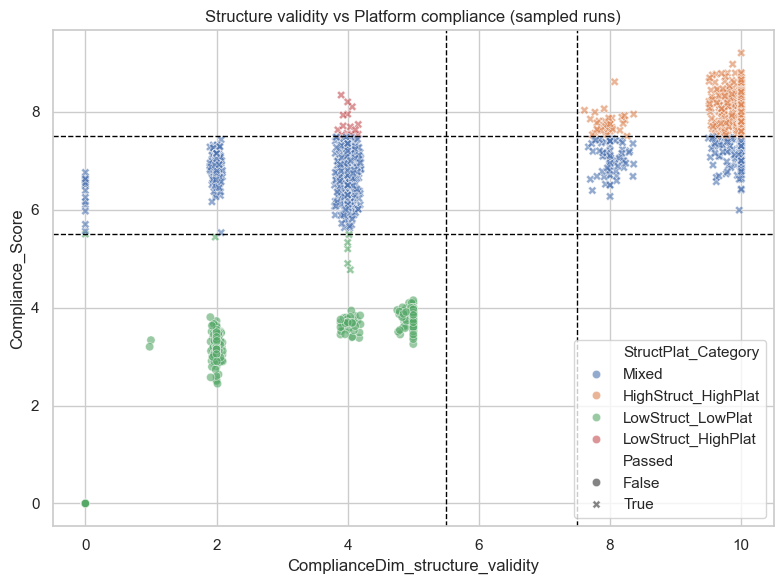

TABLE P7: Pipeline-level frequency of mismatch regimes (LowStruct_HighPlat / HighStruct_LowPlat)
                                                                                         Pipeline_ID StructPlat_Category  N_runs  N_total_runs  Frac%  Pass%   ORT  Combined  Struct  Plat
         synthetic-generator-v2__synthetic_staged_etl_00_healthcare_claims_processing.py_description  LowStruct_HighPlat       4           234    1.7  100.0 3.540     7.352   4.062 7.890
                                                   peterbull__bodhi-cast__log_cleanup.py_description  LowStruct_HighPlat       3           213    1.4  100.0 1.957     6.967   4.050 7.623
             synthetic-generator-v2__synthetic_branch_merge_01_fraud_detection_triage.py_description  LowStruct_HighPlat       3           234    1.3  100.0 1.910     7.197   4.017 7.607
           synthetic-generator-v2__synthetic_branch_merge_03_regulatory_report_router.py_description  LowStruct_HighPlat       3           234    1.3  100.

In [2]:
# %% [markdown]
# # Structural validity vs Platform compliance regimes (with ORT + pipeline metadata)
#
# **Goal**
# Investigate cases where:
# - Platform compliance is high but DAG structure validity drops (LowStruct_HighPlat)
# - DAG structure validity is high but platform compliance drops (HighStruct_LowPlat)
#
# We:
# 1) Create 4 regimes based on thresholds:
#    - HighStruct_HighPlat
#    - LowStruct_HighPlat  (reviewer counterexamples)
#    - LowStruct_LowPlat
#    - HighStruct_LowPlat  (often rare)
# 2) Summarize by:
#    - overall (run-level)
#    - Method × regime
#    - Orchestrator × regime
#    - Method × Orchestrator × regime (compact)
# 3) Pipeline-level: find pipelines that frequently produce these counterexamples.
# 4) Show representative examples (top/bottom) with metadata.
#
# Uses: all_sessions_cleaned.csv (NOT consolidated_results.csv)

# %%
import json
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 240)

# %% [markdown]
# ## 0) Paths + key parameters

# %%
CSV_PATH = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv"
META_JSON_PATH = "/Users/abubakarialidu/Desktop/Data Result/pipeline_analysis_results/pipeline_analysis_complete.json"

# Regime thresholds (tune if needed)
HIGH_THR = 7.5
LOW_THR  = 5.5

STRUCT_COL = "ComplianceDim_structure_validity"  # structural validity of DAG
PLAT_COL   = "Compliance_Score"                 # overall platform compliance

# ORT weights (match your main analysis)
ALPHA_CRIT = 2.0
BETA_MAJOR = 1.0
GAMMA_MINOR = 0.25

METHOD_ORDER = [
    "Direct (Non-Reasoning)",
    "Prompt2DAG (Template)",
    "Prompt2DAG (LLM)",
    "Prompt2DAG (Hybrid)",
    "Direct (Reasoning)",
]
ORCH_ORDER = ["airflow", "dagster", "prefect"]

# How many representative examples to show in printed tables
TOP_K = 10

# %% [markdown]
# ## 1) Load data + sanity check required columns

# %%
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

required = [
    "Pipeline_ID", "Workflow", "Strategy", "Orchestrator", "Passed",
    "Static_Score", "Compliance_Score", "Combined_Score",
    STRUCT_COL
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["Orchestrator"] = df["Orchestrator"].astype(str).str.lower().str.strip()
if df["Passed"].dtype != bool:
    df["Passed"] = df["Passed"].astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False})

print("Non-NaN counts:")
print(f"  {STRUCT_COL}: {df[STRUCT_COL].notna().sum():,}")
print(f"  {PLAT_COL}:   {df[PLAT_COL].notna().sum():,}")

# %% [markdown]
# ## 2) 5-method classification (same as your main analysis)

# %%
def classify_method(row):
    workflow = row.get("Workflow", "")
    strategy = str(row.get("Strategy") or "").lower()
    if workflow == "Direct":
        return "Direct (Non-Reasoning)"
    elif workflow == "Reasoning":
        return "Direct (Reasoning)"
    elif workflow == "Prompt2DAG":
        if "template" in strategy:
            return "Prompt2DAG (Template)"
        elif "llm" in strategy:
            return "Prompt2DAG (LLM)"
        elif "hybrid" in strategy:
            return "Prompt2DAG (Hybrid)"
        else:
            return f"Prompt2DAG ({row.get('Strategy','Unknown')})"
    return workflow

df["Method"] = df.apply(classify_method, axis=1)
df = df[df["Method"].isin(METHOD_ORDER)].copy()

print("\nRows per Method:")
print(df["Method"].value_counts().reindex(METHOD_ORDER))

# %% [markdown]
# ## 3) Compute ORT (capped 0–10) consistent with the regime analysis goal
#
# For this regime analysis, it’s often clearer to use ORT *capped* (0–10) rather than scaled.
# (Scaled is fine too, but capped is directly interpretable and stable.)

# %%
for c in ["Critical_Issues", "Major_Issues", "Minor_Issues"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = df[c].fillna(0)

df["Total_Issues"] = df["Critical_Issues"] + df["Major_Issues"] + df["Minor_Issues"]

df["Base_Score"] = np.where(df["Passed"] == True, df["Combined_Score"], 0.0)
df["Penalty"] = (
    ALPHA_CRIT * df["Critical_Issues"]
    + BETA_MAJOR * df["Major_Issues"]
    + GAMMA_MINOR * df["Minor_Issues"]
)
df["ORT_raw"] = df["Base_Score"] - df["Penalty"]
df["ORT_capped"] = df["ORT_raw"].clip(lower=0.0, upper=10.0)

print("\nCorr(Combined, ORT_capped):")
print(df[["Combined_Score","ORT_capped"]].corr().round(3).to_string())

# %% [markdown]
# ## 4) Define the 4 regimes: structure × platform

# %%
df_sp = df.dropna(subset=[STRUCT_COL, PLAT_COL]).copy()
print("Rows with both structure + platform:", len(df_sp))

def classify_struct_plat(s, p, high_thr=HIGH_THR, low_thr=LOW_THR):
    high_s = s >= high_thr
    low_s  = s <= low_thr
    high_p = p >= high_thr
    low_p  = p <= low_thr

    if high_s and high_p:
        return "HighStruct_HighPlat"
    if low_s and high_p:
        return "LowStruct_HighPlat"
    if low_s and low_p:
        return "LowStruct_LowPlat"
    if high_s and low_p:
        return "HighStruct_LowPlat"
    return "Mixed"

df_sp["StructPlat_Category"] = df_sp.apply(lambda r: classify_struct_plat(r[STRUCT_COL], r[PLAT_COL]), axis=1)

print("\nCategory counts:")
print(df_sp["StructPlat_Category"].value_counts())

# %% [markdown]
# ## 5) Run-level summary per category (overall)
#
# This is a compact “Table D1” analog for the paper appendix.

# %%
summary_cols = [
    STRUCT_COL, PLAT_COL,
    "Static_Score", "Compliance_Score", "Combined_Score",
    "ORT_capped",
    "Total_Issues", "Critical_Issues", "Major_Issues", "Minor_Issues",
    "Passed"
]

cat_summary = (
    df_sp
    .groupby("StructPlat_Category")[summary_cols]
    .agg({
        STRUCT_COL: "mean",
        PLAT_COL: "mean",
        "Static_Score":"mean",
        "Compliance_Score":"mean",
        "Combined_Score":"mean",
        "ORT_capped":"mean",
        "Total_Issues":"mean",
        "Critical_Issues":"mean",
        "Major_Issues":"mean",
        "Minor_Issues":"mean",
        "Passed":"mean"
    })
    .rename(columns={"Passed":"Pass_Rate"})
)

counts = df_sp["StructPlat_Category"].value_counts().rename("N_runs")
cat_summary = cat_summary.join(counts, how="left")
cat_summary["Pass%"] = 100*cat_summary["Pass_Rate"]
cat_summary = cat_summary.drop(columns=["Pass_Rate"]).round(3)

print("="*120)
print("TABLE R1: Run-level means by Struct×Platform regime (all methods)")
print("="*120)
print(cat_summary.to_string())

# %% [markdown]
# ## 6) Where do these regimes come from? (Method × regime, Orchestrator × regime)
#
# These tables answer:
# - Is LowStruct_HighPlat mainly a Prompt2DAG phenomenon? (it often is)
# - Is it orchestrator-specific?
#
# We report both frequency and mean ORT.

# %%
def regime_breakdown(group_cols):
    tmp = (
        df_sp
        .groupby(group_cols + ["StructPlat_Category"], observed=True)
        .agg(
            N=("Pipeline_ID", "size"),
            Pass_Rate=("Passed","mean"),
            ORT=("ORT_capped","mean"),
            Combined=("Combined_Score","mean"),
            Struct=("ComplianceDim_structure_validity","mean"),
            Plat=("Compliance_Score","mean"),
        )
        .reset_index()
    )
    tmp["Pass%"] = (100*tmp["Pass_Rate"]).round(1)
    tmp["ORT"] = tmp["ORT"].round(2)
    tmp["Combined"] = tmp["Combined"].round(2)
    tmp = tmp.drop(columns=["Pass_Rate"])
    return tmp.sort_values(group_cols + ["StructPlat_Category"])

print("\n" + "="*120)
print("TABLE R2: Method × Regime (run-level)")
print("="*120)
print(regime_breakdown(["Method"]).to_string(index=False))

print("\n" + "="*120)
print("TABLE R3: Orchestrator × Regime (run-level)")
print("="*120)
print(regime_breakdown(["Orchestrator"]).to_string(index=False))

# Compact 3D view for appendix diagnostics
print("\n" + "="*120)
print("TABLE R4: Orchestrator × Method × Regime (run-level; compact metrics)")
print("="*120)
r4 = regime_breakdown(["Orchestrator","Method"])
print(r4[["Orchestrator","Method","StructPlat_Category","N","Pass%","ORT","Combined","Struct","Plat"]].to_string(index=False))

# %% [markdown]
# ## 7) Visual: scatter of Structure vs Platform compliance
#
# This gives an intuitive picture for reviewers.

# %%
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sp.sample(min(2500, len(df_sp)), random_state=42),
    x=STRUCT_COL, y=PLAT_COL,
    hue="StructPlat_Category",
    style="Passed",
    alpha=0.6
)
plt.axvline(LOW_THR, color="black", linestyle="--", linewidth=1)
plt.axvline(HIGH_THR, color="black", linestyle="--", linewidth=1)
plt.axhline(LOW_THR, color="black", linestyle="--", linewidth=1)
plt.axhline(HIGH_THR, color="black", linestyle="--", linewidth=1)
plt.title("Structure validity vs Platform compliance (sampled runs)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8) Pipeline-level analysis: which pipelines generate LowStruct_HighPlat (and vice versa)?
#
# Instead of listing all pipelines, we compute per pipeline:
# - fraction of runs in each regime
# - mean ORT / pass rate in that regime
#
# This tells you:
# - whether “counterexamples” are concentrated in a few pipelines or widespread.

# %%
pipe_regime = (
    df_sp
    .groupby(["Pipeline_ID","StructPlat_Category"], observed=True)
    .agg(
        N_runs=("Passed","size"),
        Pass_Rate=("Passed","mean"),
        ORT=("ORT_capped","mean"),
        Combined=("Combined_Score","mean"),
        Struct=("ComplianceDim_structure_validity","mean"),
        Plat=("Compliance_Score","mean")
    )
    .reset_index()
)

# total runs per pipeline (in df_sp)
pipe_tot = df_sp.groupby("Pipeline_ID").size().rename("N_total_runs").reset_index()

pipe_regime = pipe_regime.merge(pipe_tot, on="Pipeline_ID", how="left")
pipe_regime["Frac_of_pipeline"] = pipe_regime["N_runs"] / pipe_regime["N_total_runs"]

# focus on the two "mismatch" regimes
mismatch = pipe_regime[pipe_regime["StructPlat_Category"].isin(["LowStruct_HighPlat","HighStruct_LowPlat"])].copy()
mismatch["Pass%"] = (100*mismatch["Pass_Rate"]).round(1)
mismatch["Frac%"] = (100*mismatch["Frac_of_pipeline"]).round(1)

print("="*120)
print("TABLE P7: Pipeline-level frequency of mismatch regimes (LowStruct_HighPlat / HighStruct_LowPlat)")
print("="*120)
print(
    mismatch.sort_values(["StructPlat_Category","Frac_of_pipeline"], ascending=[True, False])
            [["Pipeline_ID","StructPlat_Category","N_runs","N_total_runs","Frac%","Pass%","ORT","Combined","Struct","Plat"]]
            .head(30)
            .round(3)
            .to_string(index=False)
)

# %% [markdown]
# ## 9) Add metadata to the pipeline-level mismatch table (domain/topology/complexity)
#
# This provides paper-friendly interpretation without listing everything.

# %%
# Load minimal metadata columns (optional; will still run without metadata)
if Path(META_JSON_PATH).exists():
    with open(META_JSON_PATH, "r", encoding="utf-8") as f:
        meta_json = json.load(f)

    meta_records = []
    for e in meta_json.get("analyses", []):
        src = e.get("source_file", "")
        pid = src.replace(".txt", "")
        topo = e.get("topology", {}) or {}
        comp = e.get("complexity", {}) or {}
        ext  = e.get("external_services", {}) or {}

        # Use standard_complexity_score if present
        std_c = comp.get("standard_complexity_score", None)
        raw_c = comp.get("complexity_score", None)
        use_c = std_c if std_c is not None else raw_c

        meta_records.append({
            "Pipeline_ID": pid,
            "pipeline_name": e.get("pipeline_name", pid),
            "domain_category": e.get("domain_category"),
            "topology_pattern": topo.get("pattern"),
            "parallelization_level": topo.get("parallelization_level"),
            "has_sensors": topo.get("has_sensors"),
            "has_branches": topo.get("has_branches"),
            "integration_pattern": ext.get("service_integration_pattern"),
            "std_complexity": use_c
        })
    df_meta = pd.DataFrame(meta_records)
else:
    df_meta = pd.DataFrame(columns=["Pipeline_ID"])

mismatch_meta = mismatch.merge(df_meta, on="Pipeline_ID", how="left")

print("="*120)
print("TABLE P8: Mismatch regimes with metadata (top 30 by fraction within pipeline)")
print("="*120)
print(
    mismatch_meta.sort_values(["StructPlat_Category","Frac_of_pipeline"], ascending=[True, False])
                [["Pipeline_ID","pipeline_name","domain_category","topology_pattern","parallelization_level",
                  "has_sensors","has_branches","integration_pattern","std_complexity",
                  "StructPlat_Category","Frac%","N_runs","N_total_runs","Pass%","ORT","Struct","Plat"]]
                .head(30)
                .round(3)
                .to_string(index=False)
)

# %% [markdown]
# ## 10) Representative run-level counterexamples with full context
#
# Reviewers usually want concrete examples.
# We will show:
# - Top K worst structure among High platform (LowStruct_HighPlat)
# - Top K worst platform among High structure (HighStruct_LowPlat) if any
#
# We include: Pipeline_ID, Method, Orchestrator, key compliance dims, ORT, issues.

# %%
def sample_examples(df_sub, n=TOP_K, sort_by=None, ascending=True):
    if sort_by is not None and sort_by in df_sub.columns:
        df_sub = df_sub.sort_values(sort_by, ascending=ascending)

    cols = [
        "Pipeline_ID", "Method", "Workflow", "Orchestrator", "Strategy",
        STRUCT_COL, "Compliance_Score",
        "ComplianceDim_loadability", "ComplianceDim_executability",
        "ComplianceDim_configuration_validity", "ComplianceDim_task_validity",
        "Static_Score", "Combined_Score", "ORT_capped",
        "Total_Issues", "Critical_Issues", "Major_Issues", "Minor_Issues",
        "Grade", "Passed"
    ]
    cols = [c for c in cols if c in df_sub.columns]
    return df_sub[cols].head(n).round(3)

# LowStruct_HighPlat examples: sort by structure ascending (worst structure first)
lshp = df_sp[df_sp["StructPlat_Category"] == "LowStruct_HighPlat"].copy()
print("="*120)
print("RUN EXAMPLES: LowStruct_HighPlat (structure low, platform high)")
print("="*120)
print(sample_examples(lshp, n=TOP_K, sort_by=STRUCT_COL, ascending=True).to_string(index=False))

# HighStruct_LowPlat examples (may be empty)
hslp = df_sp[df_sp["StructPlat_Category"] == "HighStruct_LowPlat"].copy()
print("\n" + "="*120)
print("RUN EXAMPLES: HighStruct_LowPlat (structure high, platform low)")
print("="*120)
if len(hslp) == 0:
    print("No examples found under current thresholds.")
else:
    print(sample_examples(hslp, n=TOP_K, sort_by=PLAT_COL, ascending=True).to_string(index=False))

# %% [markdown]
# ## 11) Prompt2DAG-only: are counterexamples concentrated in a specific strategy?
#
# This is usually the reviewer-relevant subset.

# %%
p2d = df_sp[df_sp["Method"].str.startswith("Prompt2DAG")].copy()

p2d_lshp = p2d[p2d["StructPlat_Category"] == "LowStruct_HighPlat"].copy()
print("="*120)
print("Prompt2DAG-only LowStruct_HighPlat runs (top worst structure)")
print("="*120)
print(sample_examples(p2d_lshp, n=TOP_K, sort_by=STRUCT_COL, ascending=True).to_string(index=False))

# %% [markdown]
# ## 12) Threshold sensitivity (optional but good)
#
# Reviewer question: "are these counterexamples an artifact of thresholds?"
# This quick sweep reports how many runs fall into each regime under several thresholds.

# %%
def count_regimes(high_thr, low_thr):
    tmp = df.dropna(subset=[STRUCT_COL, PLAT_COL]).copy()
    tmp["cat"] = tmp.apply(lambda r: classify_struct_plat(r[STRUCT_COL], r[PLAT_COL], high_thr, low_thr), axis=1)
    vc = tmp["cat"].value_counts()
    return {
        "high_thr": high_thr,
        "low_thr": low_thr,
        "HighStruct_HighPlat": int(vc.get("HighStruct_HighPlat", 0)),
        "LowStruct_HighPlat": int(vc.get("LowStruct_HighPlat", 0)),
        "LowStruct_LowPlat": int(vc.get("LowStruct_LowPlat", 0)),
        "HighStruct_LowPlat": int(vc.get("HighStruct_LowPlat", 0)),
        "Mixed": int(vc.get("Mixed", 0)),
        "Total": int(vc.sum())
    }

sweep = []
for high_thr in [7.0, 7.5, 8.0]:
    for low_thr in [5.0, 5.5, 6.0]:
        if low_thr >= high_thr:
            continue
        sweep.append(count_regimes(high_thr, low_thr))

sweep_df = pd.DataFrame(sweep)
print("="*120)
print("Threshold sensitivity table: counts of regimes under different (high,low) thresholds")
print("="*120)
print(sweep_df.to_string(index=False))